## [CMPE255] Group Project: Cropland Classification

####  Group3 
Baijun Jian (013723034), Karen Lee (014521052), Kavyashree Chandrashekar (013856518)
#### Dataset
UCI Crop mapping using fused optical-radar dataset:
https://archive.ics.uci.edu/ml/datasets/Crop+mapping+using+fused+optical-radar+data+set

In [ ]:
#!/usr/local/cuda/bin/nvcc --version
#!nvidia-smi

In [ ]:
#import tensorflow as tf 
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Load Dataset

In [ ]:
# Download it using wget (Linux) or manually download it and place on the same folder as this notebook
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00525/data.zip

--2020-11-30 04:58:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00525/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158060686 (151M) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>] 150.74M  48.5MB/s    in 3.1s    

2020-11-30 04:58:04 (48.5 MB/s) - ‘data.zip’ saved [158060686/158060686]



In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: WinnipegDataset.txt     


In [ ]:
df = pd.read_csv('WinnipegDataset.txt', sep=',')
df.shape

(325834, 175)

### Data Exploration

In [ ]:
df.head(5)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,...,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,...,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,...,0.30864,0.613940,6215,5035,3033,3837,8588,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,...,0.16049,0.064018,6836,5745,4212,4534,7691,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,...,0.20988,0.657600,6682,5883,4434,4627,7072,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Columns: 175 entries, label to f174
dtypes: float64(169), int64(6)
memory usage: 435.0 MB


In [ ]:
df.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,...,0.669702,0.535537,6155.009207,5429.189523,3224.350943,4651.873460,10335.963905,0.512992,3.302018,1.708508,-1.165913,0.949212,0.769460,0.258010,0.300439,0.810907,0.371572,2.235246,0.371572,5.193413e+05,0.181069,4939.284233,173844.894271,1.458607,44.453234,0.480385,0.755551,0.929868,0.553554,1.074719,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,1.604617,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,0.596276,1.499603,1.539068,0.083552,0.020465,0.093410,0.041863,0.082040,0.045401,0.644197,0.621884,0.519517,0.668061,0.155145,0.635231,0.054490,0.020026,0.005420,0.067356,0.105147,5.775659,0.076198,0.087860,0.060233,0.030058,0.037619,0.084197,3.189013,3.663707,4.054214,...,0.286678,0.500804,245.682028,582.646612,572.939182,746.884339,2262.583966,0.117465,0.868576,0.180011,1.969942,0.186985,0.176194,0.054244,0.090148,0.126551,0.084858,0.399870,0.084858,1.699188e+05,0.066900,1758.170529,54569.523161,0.202670,5.066352,1.263675,0.165313,2.121463,0.490840,0.541818,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,1.000000,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,-2.717500,-4.281900,-4.498300,0.209190,0.015586,0.162270,0.064580,0.153900,0.075863,-6.793300,-7.756700,-7.643300,-7.676600,-2.051400,-7.383900,0.006389,0.003183,0.000264,0.307150,0.145010,17.538000,0.101970,0.020272,0.023803,0.010547,0.007286,0.021641,-22.103000,-24.520000,-34.308000,...,0.111110,-1.000000,5495.000000,4310.000000,2219.000000,2462.000000,3050.000000,-0.100680,0.817050,1.030300,-502.770000,0.003170,-0.151020,0.014904,-0.272750,-0.035341,-0.019756,0.961250,-0.019756,6.390000e+03,-0.104300,-4178.200000,-45280.000000,0.811110,27.000000,0.000000,0.027761,0.000000,0.000000,-0.000000,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,3.000000,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,-0.526397,3.141300,2.933200,0.415260,0.048986,0.382610,0.189580,0.

In [ ]:
df.isnull().sum(axis=0)

label    0
f1       0
f2       0
f3       0
f4       0
        ..
f170     0
f171     0
f172     0
f173     0
f174     0
Length: 175, dtype: int64

In [ ]:
df['label'].unique()

array([1, 2, 3, 4, 5, 6, 7])

Class=1, n=39162 (12.019%)
Class=2, n=3598 (1.104%)
Class=3, n=75673 (23.224%)
Class=4, n=74067 (22.732%)
Class=5, n=47117 (14.460%)
Class=6, n=85074 (26.110%)
Class=7, n=1143 (0.351%)


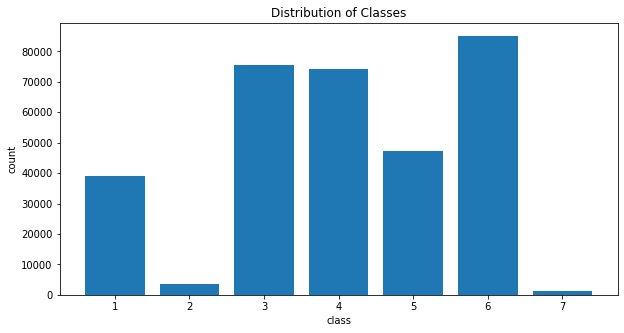

In [ ]:
from collections import Counter

counter = Counter(sorted(df['label']))

for k,v in counter.items():
    per = v/len(df['label'])*100
    print('Class=%d, n=%d (%.3f%%)'%(k, v, per))

#plot class distribution
plt.figure(figsize=(10, 5))
plt.title('Distribution of Classes')
plt.bar(counter.keys(), counter.values())
plt.xlabel('class')
plt.ylabel('count')
plt.show()

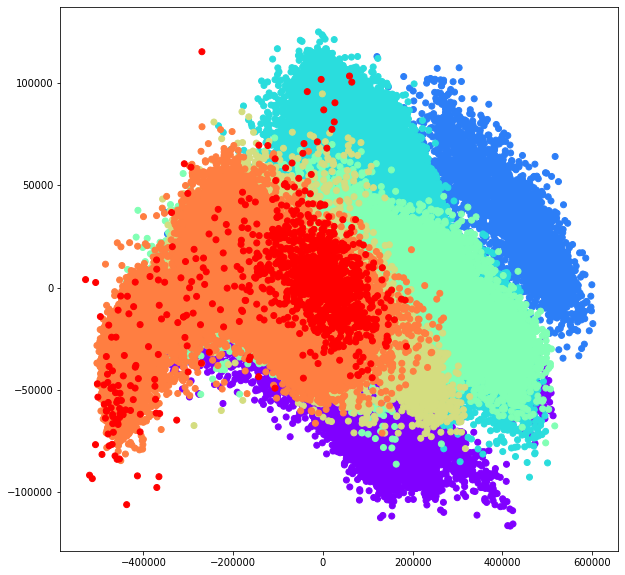

In [ ]:
features = df.iloc[:,1:]
labels = df['label']

from sklearn.decomposition import PCA 
pca = PCA(n_components = 2)
features = pca.fit_transform(features)

plt.figure(figsize = (10, 10))
plt.scatter(features[:,0], features[:,1], c=labels, cmap='rainbow')
plt.show()

### Selecting Features

Embedded methods using Lasso regularisation, SelectFromModel

In [ ]:
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [ ]:
df_copy = df.copy()

features = df_copy.iloc[:,1:]
labels = df_copy['label']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(features)

StandardScaler(copy=True, with_mean=True, with_std=True)

#### LogisticRegression L2 

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(features), labels)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [ ]:
selected_feat = features.columns[(sel_.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 174
selected features: 67


In [ ]:
np.sum(sel_.estimator_.coef_ == 0)

0

In [ ]:
X_lasso = sel_.transform(features)
y_lasso = labels

X_lasso.shape, y_lasso.shape

((325834, 67), (325834,))

#### Lasso Cross Validation(L1)

In [ ]:
sel_cv = SelectFromModel(LassoCV())
sel_cv.fit(scaler.transform(features), labels)
selected_feat = features.columns[(sel_cv.get_support())]
print('total features: {}'.format((features.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with zero: {}'.format(np.sum(sel_cv.estimator_.coef_ == 0)))

total features: 174
selected features: 45
features with zero: 129


In [ ]:
X_lasso_cv = sel_cv.transform(features)
y_lasso_cv = labels
X_lasso_cv.shape, y_lasso_cv.shape

((325834, 45), (325834,))

### Divide dataset into train and test dataset

In [ ]:
X = X_lasso
y = y_lasso

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cv, X_test_cv,y_train_cv, y_test_cv = train_test_split(X_lasso_cv, y_lasso_cv, test_size=0.3, random_state=42)


print('Train shape L2: ', X_train.shape)
print('Test shape L2: ', X_test.shape)
print('Train shape L1:', X_train_cv.shape)
print('Train shape L1:', X_test_cv.shape)

Train shape L2:  (228083, 67)
Test shape L2:  (97751, 67)
Train shape L1: (228083, 45)
Train shape L1: (97751, 45)


In [ ]:
# create training set for both L2, and L1(X_train_cv)
training_sets = [(X_train, y_train, y_test), (X_train_cv, y_train_cv, y_test_cv)]

KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, algorithm='auto')

from sklearn import random_projection
clf.fit(X_train, y_train)
y = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
score = accuracy_score(y_test, y)

print("Accuracy: {0:f}".format(score))

Accuracy: 0.740893


In [ ]:
print('F1 score:',f1_score(y_test, y, average='macro'))
print('RMSE: ', np.math.sqrt(mean_squared_error(y_test, y)))
print(classification_report(y_test, y))

F1 score: 0.6549039056315334
RMSE:  1.03519610739088
              precision    recall  f1-score   support

           1       0.87      0.85      0.86     11777
           2       0.98      0.91      0.95      1095
           3       0.96      0.96      0.96     22738
           4       0.66      0.65      0.66     22229
           5       0.44      0.43      0.43     14054
           6       0.71      0.74      0.73     25526
           7       0.00      0.00      0.00       332

    accuracy                           0.74     97751
   macro avg       0.66      0.65      0.65     97751
weighted avg       0.74      0.74      0.74     97751



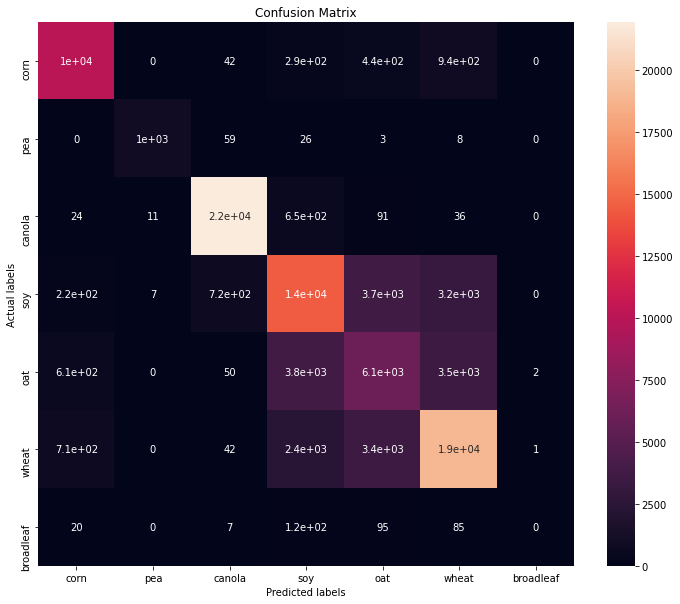

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, y)
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['corn', 'pea', 'canola', 'soy', 'oat', 'wheat', 'broadleaf']) 
ax.yaxis.set_ticklabels(['corn', 'pea', 'canola', 'soy', 'oat', 'wheat', 'broadleaf'])
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, algorithm='auto')

from sklearn import random_projection
clf.fit(X_train_cv, y_train)
y = clf.predict(X_test_cv)

In [ ]:
score = accuracy_score(y_test, y)

print("Accuracy: {0:f}".format(score))

Accuracy: 0.816084


In [ ]:
print('F1 score:',f1_score(y_test, y, average='macro'))
print('RMSE: ', np.math.sqrt(mean_squared_error(y_test, y)))
print(classification_report(y_test, y))

F1 score: 0.7141603276213583
RMSE:  1.0418256384169111
              precision    recall  f1-score   support

           1       0.78      0.78      0.78     11777
           2       0.84      0.83      0.84      1095
           3       0.98      0.99      0.98     22738
           4       0.77      0.85      0.81     22229
           5       0.67      0.68      0.67     14054
           6       0.82      0.73      0.77     25526
           7       0.82      0.08      0.15       332

    accuracy                           0.82     97751
   macro avg       0.81      0.71      0.71     97751
weighted avg       0.82      0.82      0.81     97751



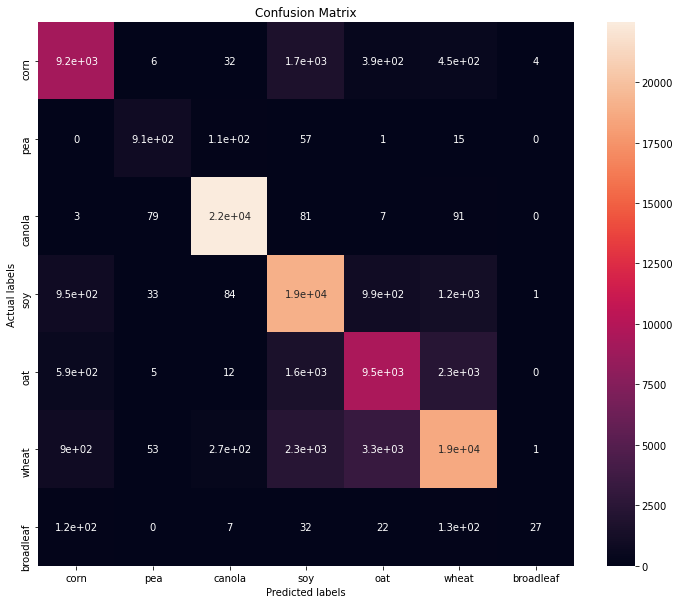

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, y)
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['corn', 'pea', 'canola', 'soy', 'oat', 'wheat', 'broadleaf']) 
ax.yaxis.set_ticklabels(['corn', 'pea', 'canola', 'soy', 'oat', 'wheat', 'broadleaf'])
plt.show()